In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# starting with mens 10000m gold metal and aiming to expand after forecasting with different events - would aim for a dropdown 
# that allows user to filter by gender, event, and medal

# Load dataset
df = pd.read_csv('data/results.csv')

# Convert result time to total seconds
def convert_result_to_seconds(result_str):
    try:
        parts = result_str.split(':')
        if len(parts) == 2:
            minutes = int(parts[0])
            seconds = float(parts[1])
            return minutes * 60 + seconds
        else:
            return np.nan
    except:
        return np.nan
# creating new column
df['Result_sec'] = df['Result'].apply(convert_result_to_seconds)

# focus on 10000M men as starting point
event_name = "800M Men"
event_df = df[df['Event'] == event_name]

event_name2 = "800M Women"
event_df2 = df[df['Event'] == event_name2]
# Pivot to get a time series of medal results over the years
pivot_df = event_df.pivot_table(index='Year', columns='Medal', values='Result_sec', aggfunc='mean').sort_index()
pivot_df2 = event_df2.pivot_table(index='Year', columns='Medal', values='Result_sec', aggfunc='mean').sort_index()
event_df2.head()



,Gender,Event,Location,Year,Medal,Name,Nationality,Result,Result_sec
2026,W,800M Women,Rio,2016,G,Caster SEMENYA,RSA,1:55.28,115.28
2027,W,800M Women,Rio,2016,S,Francine NIYONSABA,BDI,1:56.49,116.49
2028,W,800M Women,Rio,2016,B,Margaret Nyairera WAMBUI,KEN,1:56.89,116.89
2029,W,800M Women,Beijing,2008,G,Pamela JELIMO,KEN,1:54.87,114.87
2030,W,800M Women,Beijing,2008,S,Janeth Jepkosgei BUSIENEI,KEN,1:56.07,116.07


In [39]:
df['Year'].unique()

array([2016, 2008, 2000, 1992, 1984, 1976, 1968, 1960, 1952, 1936, 1928,
       1920, 2012, 2004, 1996, 1980, 1972, 1964, 1956, 1948, 1932, 1924,
       1912, 1908, 1900, 1904, 1896, 1988])

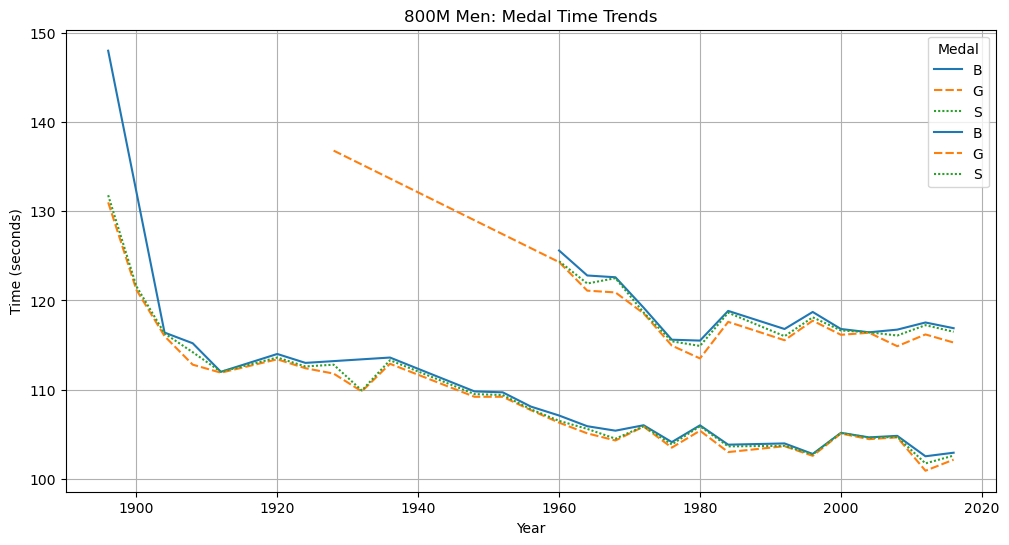

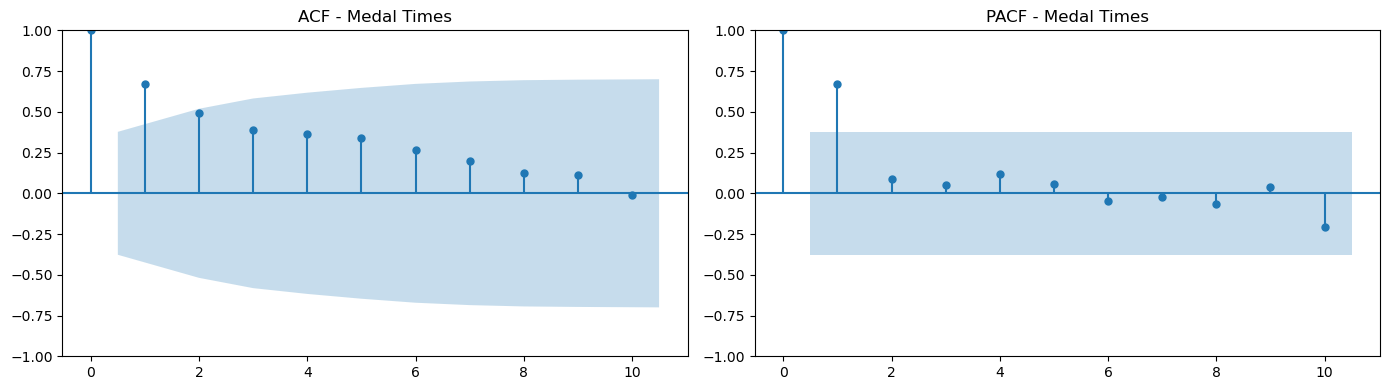

In [38]:
# line plot for medal trends over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=pivot_df)
sns.lineplot(data = pivot_df2)
plt.title(f'{event_name}: Medal Time Trends')
plt.ylabel('Time (seconds)')
plt.xlabel('Year')
plt.legend(title='Medal')
plt.grid(True)
#plt.tight_layout()
plt.show()

# ACF & PACF plots for chosen medal times
gold_series = pivot_df['G'].dropna()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(gold_series, lags=10, ax=axes[0])
plot_pacf(gold_series, lags=10, ax=axes[1])
axes[0].set_title("ACF - Medal Times")
axes[1].set_title("PACF - Medal Times")
plt.tight_layout()
plt.show()


In [3]:
#ACF - how strongly data correlates with lags
#PACF - identify significant number of lags
#both models taper off slowly... ARIMA model might be best?

/Users/avaduggan/miniconda3/envs/ds/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/avaduggan/miniconda3/envs/ds/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/avaduggan/miniconda3/envs/ds/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/avaduggan/miniconda3/envs/ds/lib/python3.9/site-packages/statsmodels/tsa/state

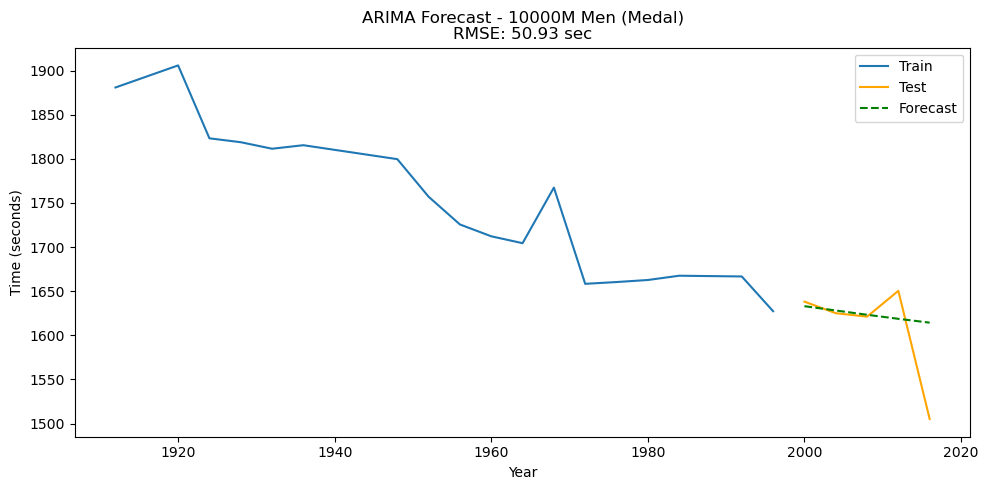

ARIMA RMSE: 50.93 seconds


,Year,Actual,ARIMA_Forecast
0,2000,1638.20,1633.029047
1,2004,1625.10,1628.159148
2,2008,1621.17,1623.306498
3,2012,1650.42,1618.713083
4,2016,1505.17,1614.370636


In [4]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# looking at gold medal time series for the selected event
gold_series = pivot_df['G'].dropna()

# training and test sets
train_size = int(len(gold_series) * 0.8)
train, test = gold_series[:train_size], gold_series[train_size:]

#will want to explore different arima model orders
# p: # of lags model uses to predict 
# d: ...
# q: moving average 

model = ARIMA(train, order=(2, 1, 2))
model_fit = model.fit()

# forecasting test set length
forecast = model_fit.forecast(steps=len(test))

# rmse
rmse = np.sqrt(mean_squared_error(test, forecast))

# actual vs forecasted values
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(test.index, forecast, label='Forecast', linestyle='--', color='green')
plt.title(f'ARIMA Forecast - {event_name} (Medal)\nRMSE: {rmse:.2f} sec')
plt.ylabel('Time (seconds)')
plt.xlabel('Year')
plt.legend()
plt.tight_layout()
plt.show()

# df to observe actual vs forecasted
comparison_df = pd.DataFrame({
    'Year': test.index,
    'Actual': test.values,
    'ARIMA_Forecast': forecast.values
}).reset_index(drop=True)

# Display the RMSE
print(f"ARIMA RMSE: {rmse:.2f} seconds")
comparison_df.head()


In [5]:
# for 10000m gold - flattened forcast, suggests performance limit

In [6]:
import warnings


def compute_arima_rmse_by_event(df, order):
    results = []
    df = df.copy()  # avoid modifying the original df

    # result column to seconds
    df['Result_sec'] = df['Result'].apply(convert_result_to_seconds)

    group_cols = ['Gender', 'Event', 'Medal']
    for (gender, event, medal), group in df.groupby(group_cols):
        series = group[['Year', 'Result_sec']].dropna().sort_values('Year')
        # want appropriate number of time points per event
        if len(series) < 10:
            continue

        ts = series.drop_duplicates(subset='Year').set_index('Year')['Result_sec']
        ts.index = pd.PeriodIndex(ts.index, freq='Y')
        
        train_size = int(len(ts) * 0.8)
        train = ts[:train_size]
        test = ts[train_size:]

        if len(test) < 2:
            continue

        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")  # suppress ARIMA warnings only here

                model = ARIMA(train, order=order)
                model_fit = model.fit()
                forecast = model_fit.forecast(steps=len(test))
                forecast.index = test.index

                rmse = np.sqrt(mean_squared_error(test, forecast))

            results.append({
                'Gender': gender,
                'Event': event,
                'Medal': medal,
                'RMSE': rmse
            })

        except Exception as e:
            continue

    results_df = pd.DataFrame(results)
    return results_df.sort_values(by='RMSE', ascending=True).reset_index(drop=True)

rmse_sorted_df1 = compute_arima_rmse_by_event(df, order = (1,1,1))
print("RMSE for gender, event, medal combinations with order (1,1,1):\n", rmse_sorted_df1)
rmse_sorted_df2 = compute_arima_rmse_by_event(df, order= (2,1,2))
print("RMSE for gender, event, medal combinations with order (2,1,2):\n", rmse_sorted_df2)

RMSE for gender, event, medal combinations with order (1,1,1):
    Gender                   Event Medal       RMSE
0       W              800M Women     S   0.904729
1       W              800M Women     G   0.996150
2       M        4X400M Relay Men     B   1.356019
3       M                800M Men     B   1.378475
4       M        4X400M Relay Men     G   1.388935
5       W              800M Women     B   1.409190
6       M                800M Men     G   1.457769
7       M                800M Men     S   1.471962
8       M        4X400M Relay Men     S   2.002239
9       W      4X400M Relay Women     G   2.156315
10      W      4X400M Relay Women     B   3.115692
11      W             1500M Women     G   6.254450
12      M               1500M Men     B   6.369361
13      M  3000M Steeplechase Men     B   6.540589
14      M               1500M Men     S   6.750837
15      M               1500M Men     G   6.884159
16      W             1500M Women     B   7.181698
17      W         

In [26]:
#currently using library for forecasting, will eventually do it manually 
#rmse interpretation for different events and figuring out how we can compare rmse between different events
#for reporting purposes... focus on a specific event or keep it broad? (would like to do dashboard)
#10000m gold rmse suggests other factors like pacing, weather, running technology may not be modeled, however 10000m S B have better performance
#visualize decomp if necessary?
#forecast future times
def scale_rmse(rmse_sorted_df):
    rmse_sorted_df['RMSE scaled'] = rmse_sorted_df['Event'].str.extract('(\d+)')
    
    for index in range(len(rmse_sorted_df)):
        value = rmse_sorted_df['RMSE scaled'][index]
        if value == 4:
            value = 1600
            rmse_sorted_df['RMSE scaled'][index] = value
    rmse_sorted_df['RMSE scaled'] = pd.to_numeric(rmse_sorted_df['RMSE scaled'], errors = 'coerce')
    rmse_sorted_df['RMSE scaled'] = rmse_sorted_df['RMSE']/rmse_sorted_df['RMSE scaled']
    return rmse_sorted_df

event_rmse = scale_rmse(rmse_sorted_df2)

event_rmse.sort_values(by = 'RMSE scaled')


,Gender,Event,Medal,RMSE,RMSE scaled
0,W,800M Women,B,0.381777,0.000477
1,W,800M Women,S,0.389658,0.000487
19,M,10000M Men,S,16.751018,0.001675
11,M,3000M Steeplechase Men,B,5.753427,0.001918
2,W,800M Women,G,1.551656,0.001940
3,M,800M Men,G,1.897102,0.002371
16,M,3000M Steeplechase Men,S,7.711965,0.002571
21,M,10000M Men,B,30.237461,0.003024
12,M,1500M Men,G,6.216495,0.004144
13,M,1500M Men,S,6.450457,0.004300


/Users/avaduggan/miniconda3/envs/ds/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/avaduggan/miniconda3/envs/ds/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/avaduggan/miniconda3/envs/ds/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ValueError: Could not interpret value `Type` for `style`. An entry with this name does not appear in `data`.

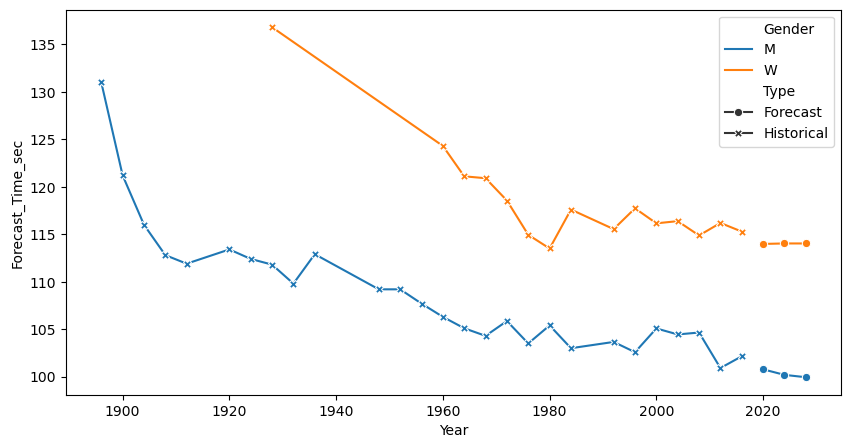

In [54]:


# Define Olympic years to forecast
olympic_years = [2020, 2024, 2028]
event_base = "800M"
all_forecasts_800m = []

# for both genders
for gender in ["M", "W"]:
    event_full = f"{event_base} {'Men' if gender == 'M' else 'Women'}"
    filtered = df[(df['Event'] == event_full) & (df['Gender'] == gender) & (df['Medal'] == 'G')]
    series = filtered[['Year', 'Result_sec']].dropna().sort_values('Year').drop_duplicates(subset='Year')

    if len(series) >= 10:
        ts = series.set_index('Year')['Result_sec']
        ts.index = pd.PeriodIndex(ts.index, freq='Y')

        try:
            model = ARIMA(ts, order=(2, 1, 2))
            model_fit = model.fit()

         
            steps = olympic_years[-1] - ts.index[-1].year
            if steps > 0:
                forecast = model_fit.forecast(steps=steps)
                forecast.index = pd.period_range(start=ts.index[-1] + 1, periods=steps, freq='Y')
                olympic_forecast = forecast[forecast.index.year.isin(olympic_years)]

                for i in range(len(olympic_forecast)):
                    all_forecasts_800m.append({
                        'Event': event_base,
                        'Gender': gender,
                        'Year': olympic_forecast.index[i].year,
                        'Forecast_Time_sec': olympic_forecast.iloc[i],
                        'Type': 'Forecast'
                    })

            # historical data
            for year, value in ts.items():
                all_forecasts_800m.append({
                    'Event': event_base,
                    'Gender': gender,
                    'Year': year.year,
                    'Forecast_Time_sec': value,
                    'Type': 'Historical'
                })

        except Exception as e:
            print(f"Error for {event_full}: {e}")
            continue


df_800m_forecast = pd.DataFrame(all_forecasts_800m)

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=df_800m_forecast,
    x='Year',
    y='Forecast_Time_sec',
    hue='Gender',
    style='Type',
    markers=True,
    dashes=False,
    palette='tab10'
)
sns.lineplot(
    data=true_vals,
    x='Year',
    y='Forecast_Time_sec',
    hue='Gender',
    style='Type',
    markers=True,
    dashes=False,
    palette='green'
)


sns.scatterplot(
    data=df_800m_forecast[df_800m_forecast['Type'] == 'Forecast'],
    x='Year',
    y='Forecast_Time_sec',
    hue='Gender',
    style='Gender',
    marker='X',
    legend=False,
    s=100
)

plt.title("800M Gold Medal Times: Historical + Forecasts (2020, 2024, 2028)")
plt.ylabel("Time (seconds)")
plt.xlabel("Year")
plt.grid(True)
plt.tight_layout()
plt.show()


In [53]:
df_800m_forecast[df_800m_forecast['Type'] == "Forecast"]
data = {'Year': [2020, 2024, 2020, 2024], 'Forecast_Time_sec': [105.06, 101.19, 115.21, 116.72], 'Gender': ['M', 'M', 'W', 'W']}
true_vals = pd.DataFrame(data)
true_vals

,Year,Forecast_Time_sec,Gender
0,2020,105.06,M
1,2024,101.19,M
2,2020,115.21,W
3,2024,116.72,W


In [ ]:
#official times
#mens 2020: 1:45:06 (105.06)
#mens 2024: 1:41:19 (101.19)
#womens 2020: 1:55:21 (115.21)
#womens 2024: 1:56:72 (116.72)